#Urdu Deepfake Audio Detection using a Simple Perceptron
This notebook implements a basic deepfake detection pipeline for Urdu audio using the CSALT-LUMS Deepfake Audio Dataset. It focuses on extracting three common audio features — MFCC, Mel Spectrogram, and Chroma — from .wav files and uses a single-layer neural network (Perceptron) for binary classification between bonafide (real) and spoofed (fake) audio samples.

#Steps Covered:
Load audio file paths and assign binary labels (0 = Bonafide, 1 = Spoofed)

Extract MFCC, Mel, and Chroma features using librosa

Train a separate Perceptron model on each feature set using TensorFlow/Keras

Evaluate performance using accuracy, precision, recall, F1-score, AUC, and confusion matrix

This notebook helps analyze how different acoustic features influence the performance of a simple neural model in detecting fake audio.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
# 2. Imports
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, confusion_matrix
)

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import EarlyStopping


In [14]:
# 3. Dataset Path
DATASET_PATH = '/content/drive/MyDrive/deepfake_detection_dataset_urdu'


In [15]:
# 4. Load File Paths and Labels
def get_audio_paths_and_labels(dataset_path):
    wav_files = []
    labels = []
    for root, _, files in os.walk(dataset_path):
        for file in files:
            if file.endswith(".wav"):
                file_path = os.path.join(root, file)
                if "Bonafide" in file_path:
                    label = 0
                elif "Tacotron" in file_path or "VITS" in file_path:
                    label = 1
                else:
                    continue
                wav_files.append(file_path)
                labels.append(label)
    return wav_files, labels

file_paths, labels = get_audio_paths_and_labels(DATASET_PATH)
labels = np.array(labels)  # ✅ Fix: convert to NumPy array


In [16]:
# 5. Feature Extraction Functions
def extract_mfcc(file_path, sr=16000, n_mfcc=13):
    y, sr = librosa.load(file_path, sr=sr)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    return np.mean(mfcc, axis=1)

def extract_mel(file_path, sr=16000, n_mels=40):
    y, sr = librosa.load(file_path, sr=sr)
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    mel_db = librosa.power_to_db(mel)
    return np.mean(mel_db, axis=1)

def extract_chroma(file_path, sr=16000):
    y, sr = librosa.load(file_path, sr=sr)
    stft = np.abs(librosa.stft(y))
    chroma = librosa.feature.chroma_stft(S=stft, sr=sr)
    return np.mean(chroma, axis=1)

def extract_features(file_paths, feature_type='mfcc'):
    features = []
    for path in tqdm(file_paths, desc=f"Extracting {feature_type.upper()}"):
        try:
            if feature_type == 'mfcc':
                feat = extract_mfcc(path)
            elif feature_type == 'mel':
                feat = extract_mel(path)
            elif feature_type == 'chroma':
                feat = extract_chroma(path)
            features.append(feat)
        except Exception as e:
            print(f"Error processing {path}: {e}")
    return np.array(features)


In [17]:
# 6. Train and Evaluate Perceptron Model
def train_perceptron(X, y, feature_name):
    print(f"\nTraining Perceptron on {feature_name.upper()} Features")

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    input_dim = X_train.shape[1]

    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    model.fit(
        X_train, y_train,
        validation_split=0.2,
        epochs=50,
        batch_size=32,
        callbacks=[early_stop],
        verbose=0
    )

    y_pred_prob = model.predict(X_test).flatten()
    y_pred = (y_pred_prob > 0.5).astype(int)

    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_prob)
    cm = confusion_matrix(y_test, y_pred)

    print("\n--- Classification Metrics ---")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall   : {recall:.4f}")
    print(f"F1-Score : {f1:.4f}")
    print(f"AUC      : {auc:.4f}")
    print("\nConfusion Matrix:")
    print(cm)

    # Confusion Matrix Plot
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Bonafide", "Fake"], yticklabels=["Bonafide", "Fake"])
    plt.title(f"{feature_name.upper()} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    return model

MFCC

Extracting MFCC: 100%|██████████| 5108/5108 [02:28<00:00, 34.41it/s]



Training Perceptron on MFCC Features
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

--- Classification Metrics ---
Accuracy : 0.8796
Precision: 0.8448
Recall   : 0.7994
F1-Score : 0.8215
AUC      : 0.9312

Confusion Matrix:
[[616  52]
 [ 71 283]]


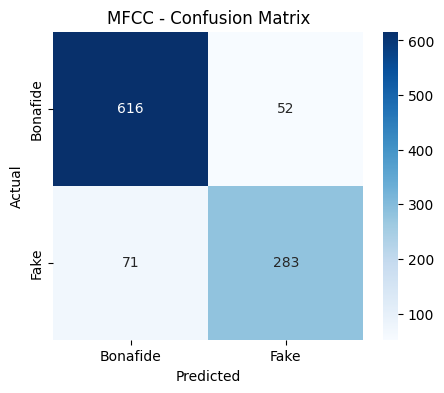

In [18]:
X_mfcc = extract_features(file_paths, 'mfcc')
perceptron_mfcc = train_perceptron(X_mfcc, labels, 'mfcc')


Mel Spectrogram

Extracting MEL: 100%|██████████| 5108/5108 [02:01<00:00, 42.05it/s]



Training Perceptron on MEL Features
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

--- Classification Metrics ---
Accuracy : 0.9070
Precision: 0.8754
Recall   : 0.8531
F1-Score : 0.8641
AUC      : 0.9449

Confusion Matrix:
[[625  43]
 [ 52 302]]


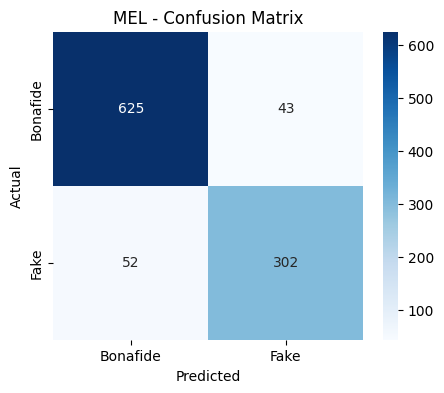

In [19]:
X_mel = extract_features(file_paths, 'mel')
perceptron_mel = train_perceptron(X_mel, labels, 'mel')


Chroma


Extracting CHROMA: 100%|██████████| 5108/5108 [03:31<00:00, 24.18it/s]



Training Perceptron on CHROMA Features
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

--- Classification Metrics ---
Accuracy : 0.7368
Precision: 1.0000
Recall   : 0.2401
F1-Score : 0.3872
AUC      : 0.8674

Confusion Matrix:
[[668   0]
 [269  85]]


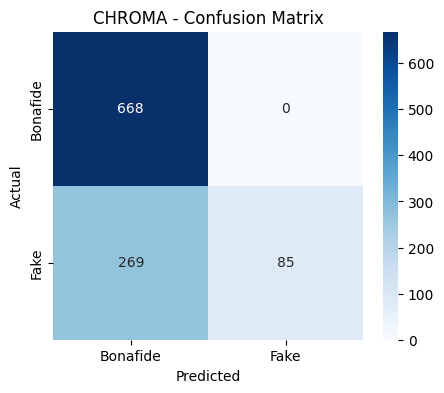

In [20]:
X_chroma = extract_features(file_paths, 'chroma')
perceptron_chroma = train_perceptron(X_chroma, labels, 'chroma')

#Final Report: Simple Perceptron on Urdu Deepfake Detection
This experiment evaluated the effectiveness of three audio feature types—MFCC, Mel Spectrogram, and Chroma—in detecting fake Urdu speech using a simple perceptron model.

#Results Summary
Feature Type	Accuracy	Precision	Recall	F1-Score	AUC
MFCC	87.96%	84.48%	79.94%	82.15%	93.12%
Mel Spectrogram	90.70%	87.54%	85.31%	86.41%	94.49%
Chroma	73.68%	100.00%	24.01%	38.72%	86.74%

#Observations
Mel Spectrogram features produced the best overall performance across all metrics. The model trained on Mel data showed high accuracy, recall, and AUC, making it most reliable for both real and fake detection.

MFCC features also gave strong results and remain a valid choice, though slightly less effective than Mel.

Chroma features led to poor recall and low F1-score, despite perfect precision. The model was overly biased toward the real class, failing to identify most fake samples.

#Conclusion
A simple perceptron performs best with Mel Spectrogram features for Urdu deepfake audio detection. Future improvements could include deeper neural networks, feature fusion (e.g., Mel + MFCC), or data augmentation to further boost performance.